In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 104)
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

import statsmodels.api as sm
from statsmodels.formula.api import ols

## Loading in data

In [2]:
df = pd.read_csv('tech_layoffs.csv')
df

,Unnamed: 0,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng,Funding
0,0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369,1700.0
1,1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850,733.0
2,2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857,116.0
3,3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369,500.0
4,4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942,15000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,1413,3286,Pitch,Berlin,Germany,Europe,80,2024-08-01,67.0,119,39,Other,Series B,$138,2024,52.52437,13.41053,138.0
1414,1414,3287,BenchSci,Toronto,Canada,North America,70,2024-08-01,17.0,412,342,Healthcare,Series D,$164,2024,43.70643,-79.39864,164.0
1415,1415,3288,NanoString Technology,Seattle,USA,North America,50,2024-08-01,9.0,556,506,Healthcare,Post-IPO,$826,2024,47.60621,-122.33207,826.0
1416,1416,3289,Trigo,Tel Aviv,Israel,Asia,30,2024-04-01,15.0,200,170,Retail,Series C,$199,2024,32.08088,34.78057,199.0


## Correcting data types

In order to prepare the data for exploratory analysis, we are going to correct the datatypes such that they are easily usable by plotting functions.

In [3]:
df.dtypes

Unnamed: 0                       int64
#                                int64
Company                         object
Location_HQ                     object
Country                         object
Continent                       object
Laid_Off                         int64
Date_layoffs                    object
Percentage                     float64
Company_Size_before_Layoffs      int64
Company_Size_after_layoffs       int64
Industry                        object
Stage                           object
Money_Raised_in_$_mil           object
Year                             int64
lat                            float64
lng                            float64
Funding                        float64
dtype: object

In [4]:
df['Funding'] = df['Money_Raised_in_$_mil'].apply(lambda s: np.float64(s[1:])) 
df['Funding'].head()

0     1700.0
1      733.0
2      116.0
3      500.0
4    15000.0
Name: Funding, dtype: float64

Industry
Consumer          52486
Retail            52065
Other             39002
Transportation    35649
Food              31024
Finance           27248
Real Estate       15102
Sales             13151
Healthcare        13069
Crypto            10374
Travel            10371
Fitness            8328
Education          8310
Hardware           7480
Marketing          7449
Security           6632
Media              6251
Infrastructure     5835
HR                 5292
Data               4960
Recruiting         4328
Logistics          4287
Construction       3703
Support            2409
Product            1401
Manufacturing       790
Aerospace           783
Legal               656
Energy              557
AI                  170
Name: Laid_Off, dtype: int64


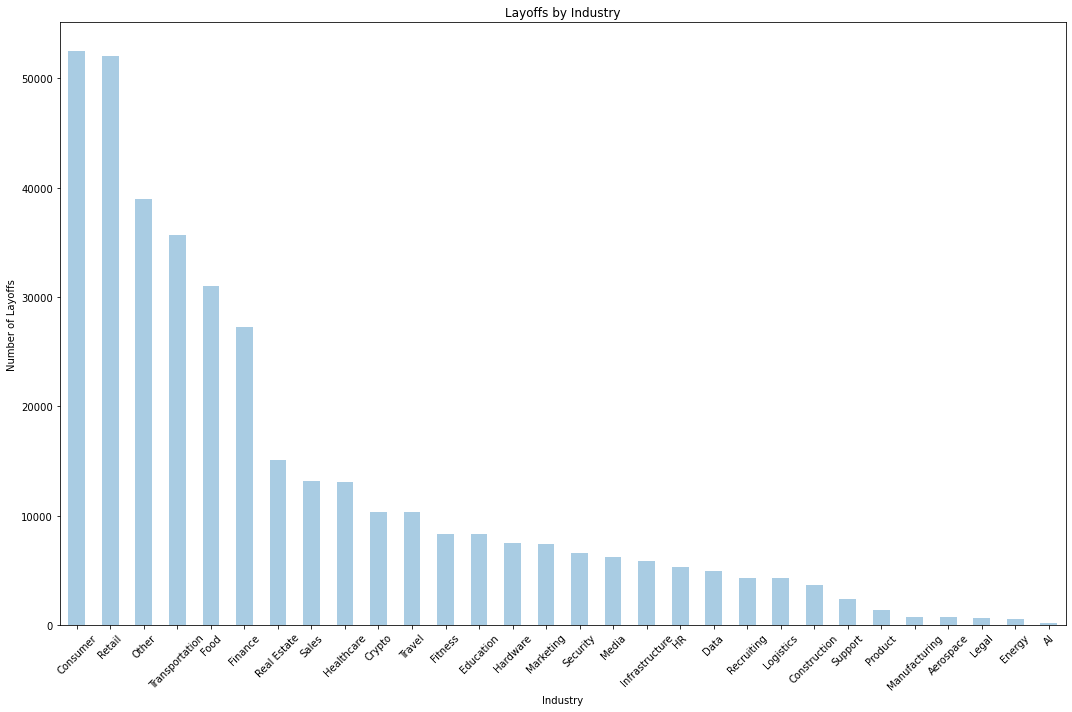

In [5]:
#group data by industry, sum laid-off values
industry_layoffs = df.groupby('Industry')['Laid_Off'].sum().sort_values(ascending=False)

print(industry_layoffs)

#plot for sum of layoffs
plt.figure(figsize = (15, 10))
industry_layoffs.plot(kind = 'bar', color = '#A9CCE3')
plt.title('Layoffs by Industry')
plt.xlabel('Industry')
plt.ylabel('Number of Layoffs')
plt.xticks(rotation=45)
plt.tight_layout()

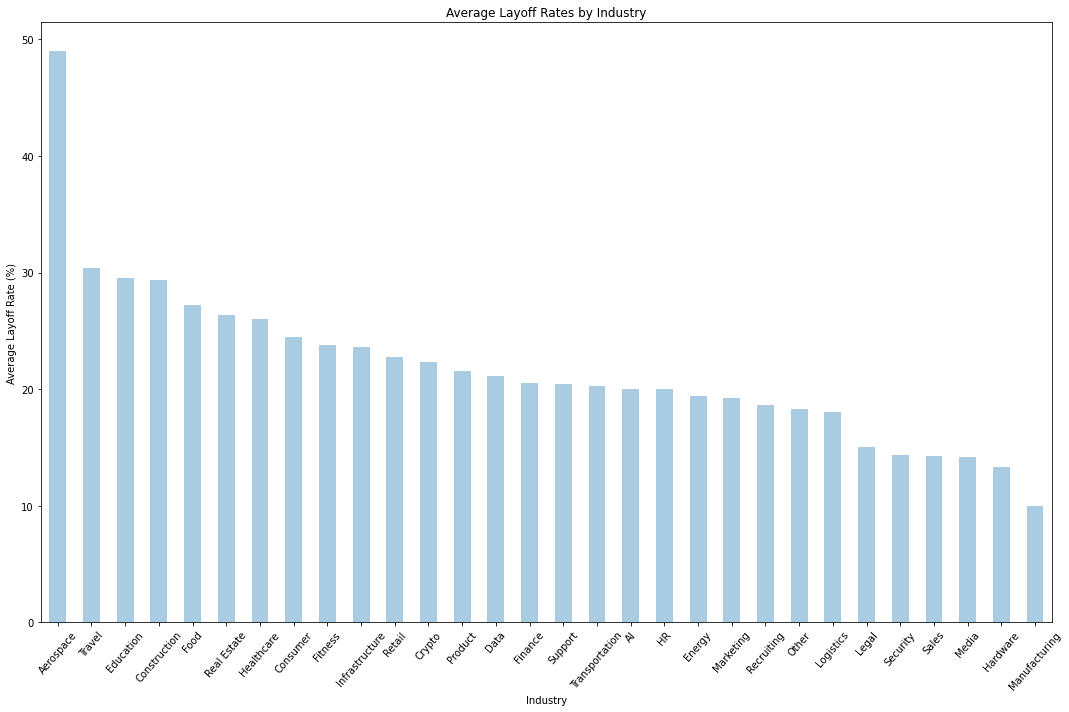

In [6]:
#group by industry percentage
industry_layoff_rates = df.groupby('Industry')['Percentage'].mean().sort_values(ascending=False)

#plot for rates
plt.figure(figsize = (15, 10))
industry_layoff_rates.plot(kind = 'bar', color = '#A9CCE3')
plt.title('Average Layoff Rates by Industry')
plt.xlabel('Industry')
plt.ylabel('Average Layoff Rate (%)')
plt.xticks(rotation=49)
plt.tight_layout()

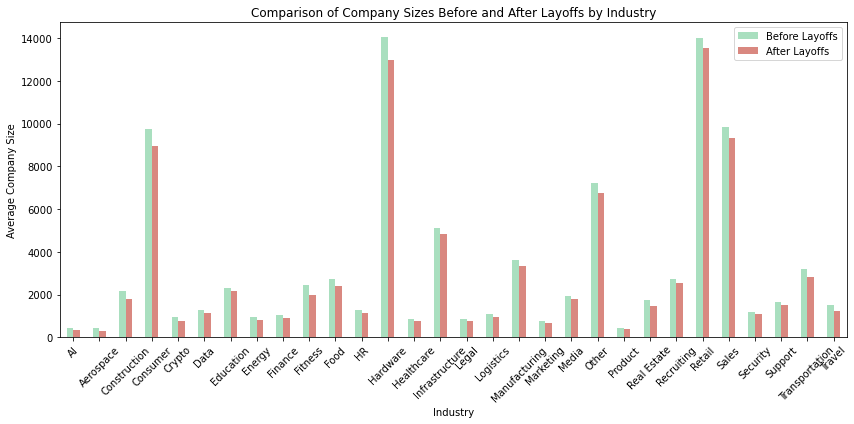

In [7]:
# company size before/after layoffs by industry
industry_sizes = df.groupby('Industry').agg({
    'Company_Size_before_Layoffs': 'mean',
    'Company_Size_after_layoffs': 'mean'
})

#plot
industry_sizes.plot(kind = 'bar', figsize = (12, 6), color  = ['#A9DFBF', '#D98880'])
plt.title('Comparison of Company Sizes Before and After Layoffs by Industry')
plt.xlabel('Industry')
plt.ylabel('Average Company Size')
plt.xticks(rotation = 45)
plt.legend(['Before Layoffs', 'After Layoffs'])
plt.tight_layout()

In [8]:
df['Date_layoffs'] = pd.to_datetime(df['Date_layoffs'])
df.sort_values('Date_layoffs', inplace=True)

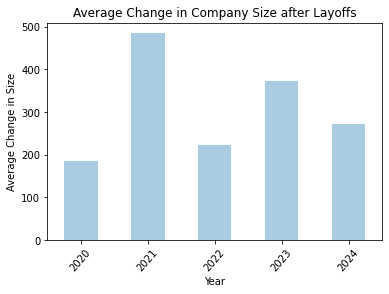

In [9]:
# change in company size
df['Change_in_Size'] = df['Company_Size_before_Layoffs'] - df['Company_Size_after_layoffs']

# plot
df.groupby(df['Date_layoffs'].dt.year)['Change_in_Size'].mean().plot(kind='bar', color = '#A9CCE3')
plt.title('Average Change in Company Size after Layoffs')
plt.xlabel('Year')
plt.ylabel('Average Change in Size')
plt.xticks(rotation=49)

plt.show()

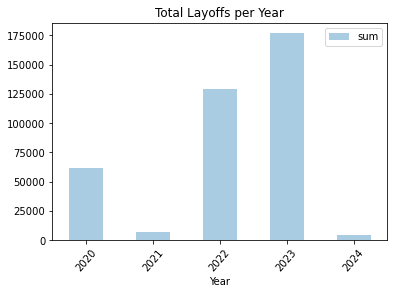

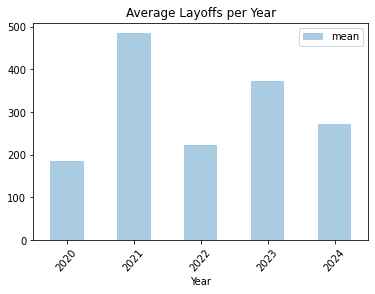

In [10]:
#group by year
df['Year'] = df['Date_layoffs'].dt.year
yearly_layoffs = df.groupby('Year')['Laid_Off'].agg(['sum', 'mean'])

# plot sum layoffs by year
yearly_layoffs.plot(kind='bar', y='sum', title='Total Layoffs per Year', color = '#A9CCE3')
plt.xticks(rotation=49)
plt.show()

#plot mean layoffs per year
yearly_layoffs.plot(kind='bar', y='mean', title='Average Layoffs per Year', color = '#A9CCE3')
plt.xticks(rotation=49)
plt.show()

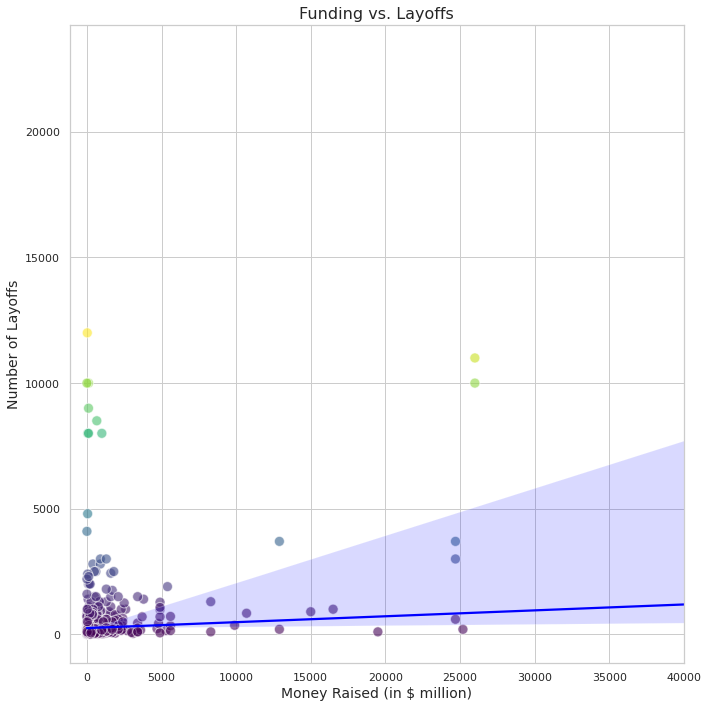

Correlation between funding and layoffs: 0.1332389969588771


In [11]:
sns.set(style="whitegrid")

# plot
plt.figure(figsize=(10, 10))  # Adjust the size of the plot
plt.scatter(df['Funding'], df['Laid_Off'], alpha=0.6, edgecolors='w', s=100, c=df['Laid_Off'], cmap='viridis') 

# line of best fit
sns.regplot(x='Funding', y='Laid_Off', data=df, scatter=False, color='blue')

plt.title('Funding vs. Layoffs', fontsize=16)
plt.xlabel('Money Raised (in $ million)', fontsize=14)
plt.ylabel('Number of Layoffs', fontsize=14)

current_xlim = plt.xlim()
plt.xlim(current_xlim[0], 35000)

current_ylim = plt.ylim()
plt.xlim(current_ylim[0], 40000) 

plt.tight_layout()
plt.show()

# calculate correlation
correlation = df['Funding'].corr(df['Laid_Off'])
print("Correlation between funding and layoffs:", correlation)

In [12]:
# t-test between lay offs 2020 v 2021

df = df.dropna(subset=['Year', 'Laid_Off'])

# extract
#group1 = df[df['Year'] == 2019]['Laid_Off']
group2 = df[df['Year'] == 2020]['Laid_Off']
group3 = df[df['Year'] == 2021]['Laid_Off']


# check groups not empty
if not group2.empty and not group3.empty:
    t_stat, p_val = stats.ttest_ind(group2, group3, nan_policy='omit')

    print(f"T-statistic: {t_stat}, P-value: {p_val}")
    
else:
    print("One or both groups are empty, cannot perform t-test.")

T-statistic: -2.6871118862417926, P-value: 0.007556343317608742


In [13]:
if p_val < 0.01:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is a significant difference!


In [14]:
# t-test between lay offs 2021 v 2022

df = df.dropna(subset=['Year', 'Laid_Off'])

# extract
#group1 = df[df['Year'] == 2019]['Laid_Off']   // 2019 df = empty, omit
#group2 = df[df['Year'] == 2020]['Laid_Off']
group3 = df[df['Year'] == 2021]['Laid_Off']
group4 = df[df['Year'] == 2022]['Laid_Off']

# check groups not empty
if not group2.empty and not group3.empty:
    t_stat, p_val = stats.ttest_ind(group3, group4, nan_policy='omit')

    print(f"T-statistic: {t_stat}, P-value: {p_val}")
    
else:
    print("One or both groups are empty, cannot perform t-test.")

T-statistic: 1.3521086863168745, P-value: 0.1768577262747666


In [15]:
if p_val < 0.01:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is NOT a significant difference!


In [16]:
# t-test between lay offs 2022 v 2023

df = df.dropna(subset=['Year', 'Laid_Off'])

# extract

group4 = df[df['Year'] == 2022]['Laid_Off']
group5 = df[df['Year'] == 2023]['Laid_Off']

# check groups not empty
if not group2.empty and not group3.empty:
    t_stat, p_val = stats.ttest_ind(group4, group5, nan_policy='omit')

    print(f"T-statistic: {t_stat}, P-value: {p_val}")
    
else:
    print("One or both groups are empty, cannot perform t-test.")

T-statistic: -2.44653785676869, P-value: 0.01458624742976463


In [17]:
if p_val < 0.01:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is NOT a significant difference!


In [18]:
# ANOVA on layoff rates by industry
df = df.dropna(subset=['Laid_Off'])

model = ols('Laid_Off ~ C(Industry)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                   sum_sq      df         F    PR(>F)
C(Industry)  5.018778e+07    29.0  2.307856  0.000105
Residual     1.040832e+09  1388.0       NaN       NaN


The low p-val suggests that there's statistically significant differences in layoff rates across different industries. 

In [21]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['Laid_Off'],     # data
                          groups=df['Industry'],    # groups
                          alpha=0.05)               # significance level

print(tukey)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1         group2      meandiff  p-adj    lower      upper   reject
---------------------------------------------------------------------------
            AI      Aerospace       71.6    1.0 -2650.1364 2793.3364  False
            AI   Construction   326.4444    1.0 -2216.6186 2869.5075  False
            AI       Consumer   710.2424    1.0 -1624.6374 3045.1223  False
            AI         Crypto      114.5    1.0  -2229.606  2458.606  False
            AI           Data    18.3333    1.0 -2329.3874  2366.054  False
            AI      Education    77.9412    1.0 -2267.0159 2422.8982  False
            AI         Energy       26.4    1.0 -2695.3364 2748.1364  False
            AI        Finance      51.24    1.0 -2260.5199 2362.9999  False
            AI        Fitness   404.8824    1.0 -2026.9542 2836.7189  False
            AI           Food   259.7111    1.0 -2065.9943 2585.4165  False
            

In [29]:
# convert to df
tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])

# filter df to show where mean difference is significant
significant_pairs = tukey_df[tukey_df['reject'] == True]

# print the significant pairs
print(significant_pairs)

       group1      group2  meandiff   p-adj      lower     upper  reject
85   Consumer        Data -691.9091  0.0092 -1309.0110  -74.8072    True
86   Consumer   Education -632.3012  0.0286 -1238.8042  -25.7983    True
88   Consumer     Finance -659.0024  0.0000 -1120.7992 -197.2056    True
91   Consumer          HR -659.5501  0.0476 -1316.5835   -2.5168    True
93   Consumer  Healthcare -669.5790  0.0004 -1181.5352 -157.6227    True
98   Consumer   Marketing -706.5639  0.0003 -1241.6591 -171.4686    True
99   Consumer       Media -662.2424  0.0205 -1283.1334  -41.3514    True
106  Consumer    Security -672.4276  0.0085 -1269.3513  -75.5039    True


Consumer industry has the lowest mean layoff rate.

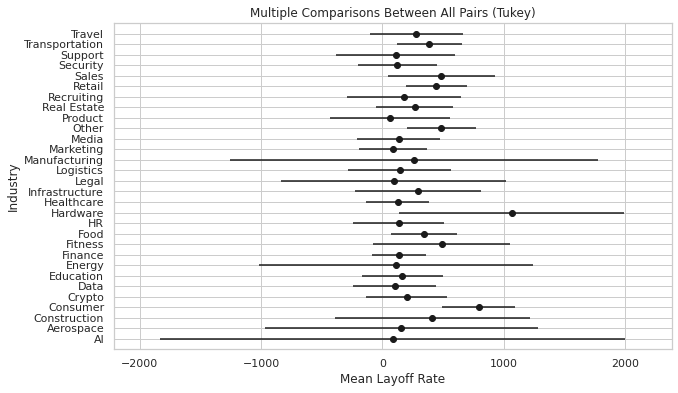

In [28]:
# plot tukey
tukey.plot_simultaneous(xlabel='Mean Layoff Rate', ylabel='Industry')   
plt.show()

Hardware has higher than average layoff rates.